In [1]:
!pip install ultralytics
!pip install grad-cam
!pip install gradio
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from ultralytics import YOLO
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import gradio as gr

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
model_path = '/content/best_finetuned.pt'

In [4]:
detection_model = YOLO(model_path)

In [5]:
def preprocess_image(image_path):
    """Preprocess image for model input"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def visualize_heatmap(image, heatmap, alpha=0.6):
    """Overlay heatmap on original image"""
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)
    return output

def plot_results(image, detections, attention_map=None):
    """Plot original image with detections and attention map"""
    plt.figure(figsize=(15, 5))

    # Original image with detections
    plt.subplot(131)
    plt.imshow(image)
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        cls = det['class']
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                        fill=False, color='red', linewidth=2))
        plt.text(x1, y1-5, f'{cls}')
    plt.title('Original Image with Detections')

    if attention_map is not None:
        # Attention map
        plt.subplot(132)
        plt.imshow(attention_map)
        plt.title('Attention Map')

        # Overlaid visualization
        plt.subplot(133)
        overlaid = visualize_heatmap(image, attention_map)
        plt.imshow(overlaid)
        plt.title('Overlaid Attention Map')

    plt.tight_layout()
    plt.show()

In [8]:
class DetectionExplainer:
    def __init__(self, model):
        self.model = model

    def generate_attention_map(self, image):
        """Generate attention map for detection using model's internal features"""
        # Get model predictions and intermediate features
        results = self.model(image, verbose=False)

        # Extract feature maps from the last layer
        feature_maps = results[0].boxes.data.cpu().numpy()

        # Create attention map from feature maps
        attention_map = np.zeros((image.shape[0], image.shape[1]))

        # Aggregate feature maps into attention map
        for box in feature_maps:
            x1, y1, x2, y2, conf, cls = box
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            attention_map[y1:y2, x1:x2] += conf

        # Normalize attention map
        attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
        return attention_map

    def explain_detection(self, image_path):
        # Load and preprocess image
        image = preprocess_image(image_path)

        # Get model predictions
        results = self.model(image, verbose=False)

        # Convert predictions to list of dictionaries
        detections = []
        for r in results:
            boxes = r.boxes
            for box in boxes:
                detections.append({
                    'bbox': box.xyxy[0].cpu().numpy(),
                    'confidence': box.conf[0].cpu().numpy(),
                    'class': r.names[int(box.cls[0].cpu().numpy())]
                })

        # Generate attention map
        attention_map = self.generate_attention_map(image)

        # Visualize results
        plot_results(image, detections, attention_map)

        return detections, attention_map

In [9]:
explainer = DetectionExplainer(detection_model)

In [10]:
image_path = '/content/17.jpg'

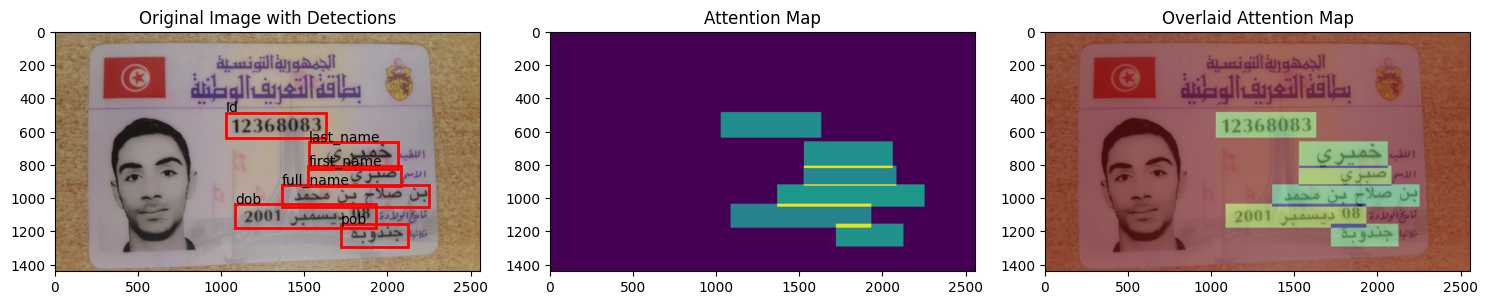

In [11]:
detections, attention_map = explainer.explain_detection(image_path)


In [12]:
image_path ="/content/cin4_back_jpg.rf.fc15b8a13e9f972ac994f301ba3f520c.jpg"

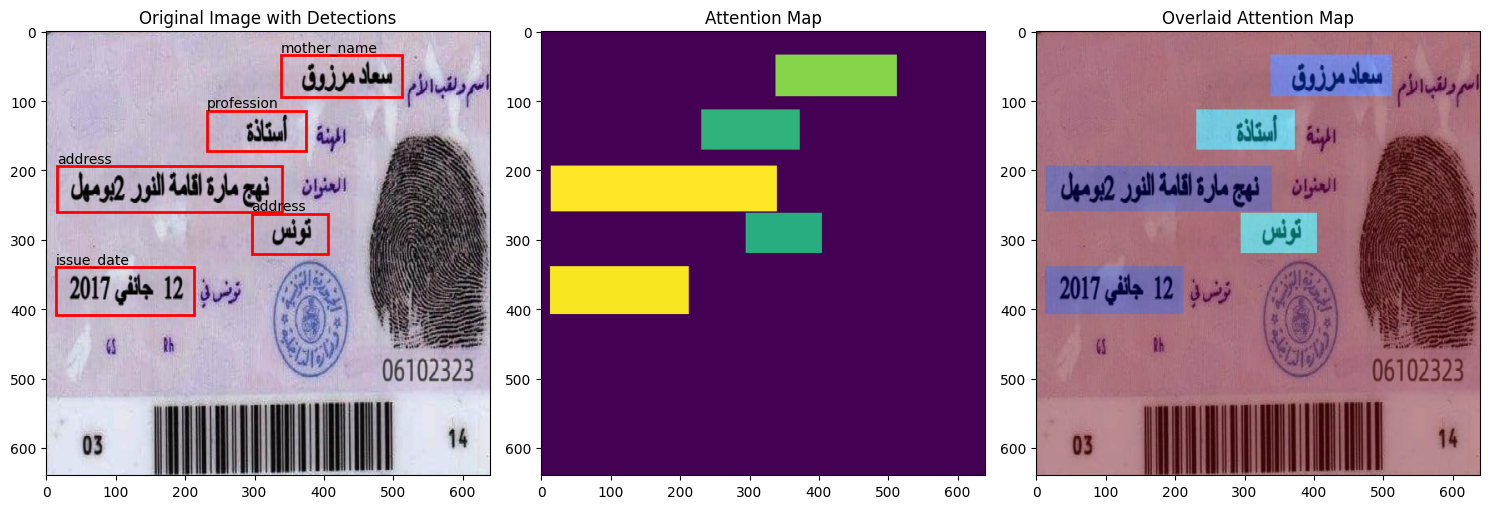

In [13]:
detections, attention_map = explainer.explain_detection(image_path)